In [27]:
import numpy as np
import torch
from torch.utils.data import Dataset

# ======================== SYNTHETIC DATA GENERATION ========================

class SyntheticTimeSeriesDataset(Dataset):
    """Generate synthetic 1D time series for diffusion model training"""

    def __init__(self,
                 num_samples: int = 1000,
                 seq_length: int = 64,
                 condition_length: int = 32,
                 task_type: str = 'forecasting'):
        """
        Args:
            num_samples: Number of time series to generate
            seq_length: Total length of each time series
            condition_length: Length of conditioning segment
            task_type: 'forecasting' or 'imputation'
        """
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.condition_length = condition_length
        self.task_type = task_type
        self.target_length = seq_length - condition_length

        # Generate all data upfront for consistency
        self.data = self._generate_data()

    def _generate_data(self):
        """Generate diverse synthetic time series patterns"""
        data = []

        for i in range(self.num_samples):
            # Mix different patterns
            pattern_type = i % 4

            if pattern_type == 0:  # Sine wave with noise
                freq = np.random.uniform(0.1, 0.5)
                phase = np.random.uniform(0, 2 * np.pi)
                amplitude = np.random.uniform(0.5, 2.0)
                t = np.linspace(0, 4 * np.pi, self.seq_length)
                series = amplitude * np.sin(freq * t + phase) + np.random.normal(0, 0.1, self.seq_length)

            elif pattern_type == 1:  # AR(1) process
                phi = np.random.uniform(0.3, 0.9)
                series = np.zeros(self.seq_length)
                series[0] = np.random.normal(0, 1)
                for t in range(1, self.seq_length):
                    series[t] = phi * series[t - 1] + np.random.normal(0, 0.3)

            elif pattern_type == 2:  # Trend with seasonality
                trend = np.linspace(np.random.uniform(-1, 1), np.random.uniform(-1, 1), self.seq_length)
                seasonal = 0.3 * np.sin(2 * np.pi * np.arange(self.seq_length) / 8)
                noise = np.random.normal(0, 0.1, self.seq_length)
                series = trend + seasonal + noise

            else:  # Random walk
                steps = np.random.normal(0, 0.2, self.seq_length)
                series = np.cumsum(steps)

            # Normalize to [-1, 1]
            series = (series - series.mean()) / (series.std() + 1e-8)
            series = np.clip(series, -3, 3) / 3

            data.append(series.astype(np.float32))

        return np.array(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        series = self.data[idx]

        if self.task_type == 'forecasting':
            # Use first part as condition, predict the rest
            target = series[self.condition_length:]
            mask = np.concatenate([np.ones(self.condition_length), np.zeros(self.target_length)])

            # Make condition tensor full length, zeroing out the target region
            condition = series.copy()
            condition[self.condition_length:] = 0

        else:  # imputation
            # Randomly mask some values in the middle
            condition = series.copy()
            mask = np.ones(self.seq_length)

            # Create random gaps
            gap_start = np.random.randint(self.condition_length // 2, self.seq_length - self.target_length)
            gap_end = gap_start + self.target_length
            condition[gap_start:gap_end] = 0  # Zero out missing values
            mask[gap_start:gap_end] = 0
            target = series[gap_start:gap_end]

        return {
            'full_series': torch.tensor(series, dtype=torch.float32),
            'condition': torch.tensor(condition, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.float32),
            'mask': torch.tensor(mask, dtype=torch.float32)
        }



In [28]:
from typing import Optional

import torch
import torch.nn.functional as F

# ======================== NOISE SCHEDULING ========================

class NoiseScheduler:
    """Handles noise scheduling for diffusion process"""

    def __init__(self, num_timesteps: int = 1000,
                 beta_start: float = 1e-4,
                 beta_end: float = 0.02,
                 schedule_type: str = 'linear',
                 device: Optional[torch.device] = None):
        self.num_timesteps = num_timesteps
        self.device = device # Store the device

        if schedule_type == 'linear':
            self.betas = self._linear_schedule(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            self.betas = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError(f"Unsupported schedule type: {schedule_type}. Choose 'linear' or 'cosine'.")

        # Move betas to device early
        if self.device is not None:
            self.betas = self.betas.to(self.device)

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

    def _linear_schedule(self, beta_start: float, beta_end: float, num_timesteps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)

    def _cosine_schedule(self, num_timesteps: int) -> torch.Tensor:
        s = 0.008
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps, dtype=torch.float32)
        alphas_cumprod = torch.cos(((x / num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def q_sample(self,
                 x_start: torch.Tensor,
                 t: torch.Tensor,
                 mask: torch.Tensor,
                 noise: Optional[torch.Tensor] = None):
        """Forward diffusion process - add noise only to target regions"""
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.alphas_cumprod[t].sqrt().view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt().view(-1, 1)

        # Apply noise only where mask is 0 (target regions)
        noisy_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

        # Keep original values where mask is 1 (conditioning regions)
        return x_start * mask + noisy_sample * (1 - mask)


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional

# ======================== DIFFUSION MODEL ========================

class TimeSeriesDDPM:
    """Main diffusion model class"""

    def __init__(self,
                 denoiser: nn.Module,
                 noise_scheduler: NoiseScheduler,
                 device: str = 'cpu'):

        self.denoiser = denoiser.to(device)
        self.noise_scheduler = noise_scheduler
        self.device = device

    def training_step(self,
                      batch: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Single training step"""

        full_series = batch['full_series'].to(self.device)
        condition = batch['condition'].to(self.device)
        mask = batch['mask'].to(self.device)

        batch_size = full_series.shape[0]

        # Sample random timesteps
        # t.shape == [batch_size]
        t = torch.randint(0, self.noise_scheduler.num_timesteps, (batch_size,), device=self.device)

        # Add noise
        # noise.shape == [batch_size, seq_lenght]
        noise = torch.randn_like(full_series)
        noisy_series = self.noise_scheduler.q_sample(full_series, t, mask, noise)

        # Predict noise
        predicted_noise = self.denoiser(noisy_series, t, condition)

        # Compute loss only on target regions (where mask == 0)
        loss_mask = (1 - mask)
        loss = F.mse_loss(predicted_noise, noise, reduction='none')
        loss = (loss * loss_mask).sum() / loss_mask.sum()

        return loss

    @torch.no_grad()
    def p_sample(self,
                 x: torch.Tensor,
                 t: torch.Tensor,
                 condition: torch.Tensor,
                 mask: torch.Tensor):
        """Single reverse diffusion step"""
        batch_size = x.shape[0]

        # Predict noise
        predicted_noise = self.denoiser(x, t, condition)

        # Get coefficients
        alpha_t = self.noise_scheduler.alphas[t].view(-1, 1)
        alpha_cumprod_t = self.noise_scheduler.alphas_cumprod[t].view(-1, 1)
        beta_t = self.noise_scheduler.betas[t].view(-1, 1)

        # Compute mean
        coeff1 = 1 / alpha_t.sqrt()
        coeff2 = beta_t / (1 - alpha_cumprod_t).sqrt()
        mean = coeff1 * (x - coeff2 * predicted_noise)

        # Add noise (except for t=0)
        if t[0] > 0:
            posterior_variance = self.noise_scheduler.posterior_variance[t].view(-1, 1)
            noise = torch.randn_like(x)
            x_prev = mean + posterior_variance.sqrt() * noise
        else:
            x_prev = mean

        # Re-impose conditioning
        x_prev = condition * mask + x_prev * (1 - mask)

        return x_prev

    @torch.no_grad()
    def sample(self,
               condition: torch.Tensor,
               mask: torch.Tensor,
               num_inference_steps: Optional[int] = None):
        """Generate samples using reverse diffusion"""
        if num_inference_steps is None:
            num_inference_steps = self.noise_scheduler.num_timesteps

        batch_size, seq_len = condition.shape

        # Start with pure noise in target regions
        x = torch.randn(batch_size, seq_len, device=self.device)
        x = condition * mask + x * (1 - mask)

        # Reverse diffusion
        timesteps = torch.linspace(self.noise_scheduler.num_timesteps - 1, 0, num_inference_steps, dtype=torch.long)

        for t in timesteps:
            t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
            x = self.p_sample(x, t_batch, condition, mask)

        return x

In [46]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import time

# ======================== TRAINING LOOP ========================

def train_model(model: TimeSeriesDDPM,
                dataloader: DataLoader,
                num_epochs: int = 100,
                learning_rate: float = 1e-3,
                device: str = 'cpu'):
    """Training loop for the diffusion model"""

    optimizer = torch.optim.Adam(model.denoiser.parameters(), lr=learning_rate)
    losses = []

    model.denoiser.train()

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_start = time.time()

        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()

            loss = model.training_step(batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.denoiser.parameters(), 1.0)

            optimizer.step()
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        epoch_time = time.time() - epoch_start

        if (epoch + 1) % 10 == 0:
            print(f"Epochloss_mask {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}, Time: {epoch_time:.2f}s")

    return losses

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class SinusoidalPositionalEmbedding(nn.Module):
    """Sinusoidal Positional Embedding for time steps."""

    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class AdaGN(nn.Module):
    """Adaptive Group Normalization conditioned on time embedding."""

    def __init__(self, num_groups: int, num_channels: int, emb_dim: int):
        super().__init__()
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.group_norm = nn.GroupNorm(num_groups, num_channels)
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * num_channels)
        )

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        # x: (batch, channels, length)
        # emb: (batch, emb_dim)

        # Apply group normalization
        x = self.group_norm(x)

        # Get scale and shift from embedding
        emb_out = self.emb_layers(emb)  # (batch, 2 * channels)
        scale, shift = emb_out.chunk(2, dim=1)  # Each: (batch, channels)

        # Apply adaptive scaling and shifting
        scale = scale.unsqueeze(-1)  # (batch, channels, 1)
        shift = shift.unsqueeze(-1)  # (batch, channels, 1)

        return x * (1 + scale) + shift


class ResidualBlock1D(nn.Module):
    """A 1D Residual Block with time and condition embeddings."""

    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int,
                 kernel_size: int = 3, num_groups: int = 8):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Time embedding projection
        self.time_emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

        # First convolution path
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.norm1 = AdaGN(num_groups, out_channels, time_emb_dim)

        # Second convolution path
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.norm2 = AdaGN(num_groups, out_channels, time_emb_dim)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor, time_emb: torch.Tensor) -> torch.Tensor:
        # x: (batch, in_channels, length)
        # time_emb: (batch, time_emb_dim)

        h = x

        # First conv block
        h = self.conv1(h)
        h = self.norm1(h, time_emb)
        h = F.silu(h)

        # Add time embedding
        time_proj = self.time_emb_proj(time_emb).unsqueeze(-1)  # (batch, out_channels, 1)
        h = h + time_proj

        # Second conv block
        h = self.conv2(h)
        h = self.norm2(h, time_emb)
        h = F.silu(h)

        # Residual connection
        return h + self.shortcut(x)


class AttentionBlock1D(nn.Module):
    """Self-attention block for 1D sequences."""

    def __init__(self, channels: int, num_heads: int = 8):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        assert channels % num_heads == 0, "channels must be divisible by num_heads"

        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.proj_out = nn.Conv1d(channels, channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, channels, length)
        batch, channels, length = x.shape

        h = self.norm(x)
        qkv = self.qkv(h)  # (batch, 3*channels, length)

        # Reshape for multi-head attention
        qkv = qkv.view(batch, 3, self.num_heads, self.head_dim, length)
        q, k, v = qkv.unbind(1)  # Each: (batch, num_heads, head_dim, length)

        # Compute attention
        q = q.transpose(-2, -1)  # (batch, num_heads, length, head_dim)
        k = k.transpose(-2, -1)  # (batch, num_heads, length, head_dim)
        v = v.transpose(-2, -1)  # (batch, num_heads, length, head_dim)

        # Scaled dot-product attention
        scale = (self.head_dim ** -0.5)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)

        out = torch.matmul(attn, v)  # (batch, num_heads, length, head_dim)
        out = out.transpose(-2, -1).contiguous()  # (batch, num_heads, head_dim, length)
        out = out.view(batch, channels, length)

        out = self.proj_out(out)
        return x + out


class Downsample1D(nn.Module):
    """Downsampling block with 1D convolution."""

    def __init__(self, channels: int, use_conv: bool = True):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        else:
            self.conv = nn.AvgPool1d(2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Upsample1D(nn.Module):
    """Upsampling block with ConvTranspose1D."""

    def __init__(self, channels: int, use_conv: bool = True):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.ConvTranspose1d(channels, channels, 4, stride=2, padding=1)
        else:
            self.conv = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet1D(nn.Module):
    """1D U-Net denoiser for time series - accepts single channel 2D inputs"""

    def __init__(self,
                 model_channels: int = 128,
                 num_res_blocks: int = 2,
                 attention_resolutions: tuple = (2, 4),
                 channel_mult: tuple = (1, 2, 4),
                 num_heads: int = 8,
                 dropout: float = 0.0,
                 time_embed_dim: int = None):

        super().__init__()

        if time_embed_dim is None:
            time_embed_dim = model_channels * 4

        # Fixed to single channel input/output
        self.in_channels = 1
        self.out_channels = 1
        self.model_channels = model_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.dropout = dropout

        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalPositionalEmbedding(model_channels),
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Condition embedding (for conditioning on input)
        self.cond_embed = nn.Conv1d(1, model_channels, 1)

        # Input projection
        self.input_proj = nn.Conv1d(1, model_channels, 3, padding=1)

        # Build encoder layers
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()

        # Track channels at each resolution for skip connections
        self.skip_channels = []

        ch = model_channels
        ds = 1  # Current downsampling factor

        for level, mult in enumerate(channel_mult):
            out_ch = model_channels * mult

            # Residual blocks for this level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks):
                blocks.append(ResidualBlock1D(ch, out_ch, time_embed_dim))
                ch = out_ch

                # Add attention if needed
                if ds in attention_resolutions:
                    blocks.append(AttentionBlock1D(ch, num_heads))

            self.down_blocks.append(blocks)
            self.skip_channels.append(ch)

            # Add downsampling (except for last level)
            if level < len(channel_mult) - 1:
                self.down_samples.append(Downsample1D(ch))
                ds *= 2
            else:
                self.down_samples.append(None)

        # Middle block
        self.mid_block1 = ResidualBlock1D(ch, ch, time_embed_dim)
        self.mid_attn = AttentionBlock1D(ch, num_heads)
        self.mid_block2 = ResidualBlock1D(ch, ch, time_embed_dim)

        # Build decoder layers
        self.up_blocks = nn.ModuleList()
        self.up_samples = nn.ModuleList()

        for level, mult in reversed(list(enumerate(channel_mult))):
            out_ch = model_channels * mult

            # Residual blocks for this level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks + 1):  # +1 for extra block after skip
                # First block needs to handle skip connection
                if i == 0:
                    in_ch = ch + self.skip_channels[level]  # current + skip
                else:
                    in_ch = out_ch

                blocks.append(ResidualBlock1D(in_ch, out_ch, time_embed_dim))
                ch = out_ch

                # Add attention if needed
                if ds in attention_resolutions:
                    blocks.append(AttentionBlock1D(ch, num_heads))

            self.up_blocks.append(blocks)

            # Add upsampling (except for first level in reverse)
            if level > 0:
                self.up_samples.append(Upsample1D(ch))
                ds //= 2
            else:
                self.up_samples.append(None)

        # Output projection
        self.out_norm = nn.GroupNorm(8, ch)
        self.out_conv = nn.Conv1d(ch, 1, 3, padding=1)

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor,
                condition: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            x: (batch, length) - noisy input
            timesteps: (batch,) - diffusion timesteps
            condition: (batch, length) - conditioning signal
        Returns:
            output: (batch, length) - denoised output
        """

        # Add channel dimension: (batch, length) -> (batch, 1, length)
        x = x.unsqueeze(1)
        if condition is not None:
            condition = condition.unsqueeze(1)

        # Time embedding
        time_emb = self.time_embed(timesteps)

        # Combine input with condition
        if condition is not None:
            # Add conditioning information
            cond_emb = self.cond_embed(condition)
            h = self.input_proj(x) + cond_emb
        else:
            h = self.input_proj(x)

        # Encoder path - store skip connections
        skips = []

        for level, (blocks, downsample) in enumerate(zip(self.down_blocks, self.down_samples)):
            for block in blocks:
                if isinstance(block, ResidualBlock1D):
                    h = block(h, time_emb)
                else:  # AttentionBlock1D
                    h = block(h)

            skips.append(h)

            if downsample is not None:
                h = downsample(h)

        # Middle blocks
        h = self.mid_block1(h, time_emb)
        h = self.mid_attn(h)
        h = self.mid_block2(h, time_emb)

        # Decoder path - use skip connections
        for level, (blocks, upsample) in enumerate(zip(self.up_blocks, self.up_samples)):
            # Add skip connection for first block
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)

            for block in blocks:
                if isinstance(block, ResidualBlock1D):
                    h = block(h, time_emb)
                else:  # AttentionBlock1D
                    h = block(h)

            if upsample is not None:
                h = upsample(h)

        # Output
        h = self.out_norm(h)
        h = F.silu(h)
        h = self.out_conv(h)

        # Remove channel dimension: (batch, 1, length) -> (batch, length)
        return h.squeeze(1)

In [32]:
import numpy as np
import torch
from matplotlib import pyplot as plt



# ======================== EVALUATION AND VISUALIZATION ========================

def evaluate_model(model: TimeSeriesDDPM, dataset: SyntheticTimeSeriesDataset,
                   num_samples: int = 5, num_inference_steps: int = 50):
    """Evaluate model and create visualizations"""

    model.denoiser.eval()

    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 2 * num_samples))
    if num_samples == 1:
        axes = [axes]

    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]

            condition = sample['condition'].unsqueeze(0).to(model.device)
            mask = sample['mask'].unsqueeze(0).to(model.device)
            full_series = sample['full_series'].numpy()

            # Generate prediction
            generated = model.sample(condition, mask, num_inference_steps)
            generated = generated.cpu().numpy()[0]

            # Plot
            x_axis = np.arange(len(full_series))
            axes[i].plot(x_axis, full_series, 'b-', label='Ground Truth', alpha=0.7)
            axes[i].plot(x_axis, generated, 'r--', label='Generated', alpha=0.7)

            # Highlight conditioning vs target regions
            condition_region = mask.cpu().numpy()[0] == 1
            target_region = mask.cpu().numpy()[0] == 0

            # Get y-limits for filling
            ymin, ymax = axes[i].get_ylim()

            axes[i].fill_between(x_axis, ymin, ymax, where=condition_region,
                                 alpha=0.2, color='green', label='Conditioning')
            axes[i].fill_between(x_axis, ymin, ymax, where=target_region,
                                 alpha=0.2, color='red', label='Target')

            axes[i].legend()
            axes[i].set_title(f'Sample {i + 1} - {dataset.task_type.capitalize()}')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Dataset and training parameters
seq_lenght = 64
condition_lenght = 48
num_samples = 8192
batch_size = 1024
num_epochs = 200
learning_rate = 0.001

# --- Task Definition ---
task_type = 'forecasting'
# --- Dataset Setup ---
# Create the synthetic time series dataset
dataset = SyntheticTimeSeriesDataset(num_samples = num_samples,
                                     seq_length = seq_lenght,
                                     condition_length = condition_lenght,
                                     task_type = 'forecasting')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Model Initialization ---
# Define the denoiser architecture
arch_name = 'UNET1d'
denoiser = UNet1D(
        model_channels=64,
        num_res_blocks=2,
        attention_resolutions=(2, 4),
        channel_mult=(1, 2, 4),
        num_heads=4
    ).to(device)

# Count and display the number of trainable parameters in the denoiser
num_params = sum(p.numel() for p in denoiser.parameters() if p.requires_grad)
print(f"Denoiser model parameters: {num_params:,}")

# Initialize the noise scheduler
noise_scheduler = NoiseScheduler(num_timesteps=1000, schedule_type='cosine', device=device)
# Create the Denoising Diffusion Probabilistic Model (DDPM)
ddpm_model = TimeSeriesDDPM(denoiser, noise_scheduler, device=device)

# --- Model Training ---
print(f"Starting Training for {arch_name} on {task_type}")

# Train the DDPM model
training_losses = train_model(
    ddpm_model,
    dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

Using device: cuda
Denoiser model parameters: 9,737,089
Starting Training for UNET1d on forecasting
Epochloss_mask 10/200, Loss: 0.130639, Time: 5.14s
Epochloss_mask 20/200, Loss: 0.126150, Time: 5.17s
Epochloss_mask 30/200, Loss: 0.114099, Time: 5.04s
Epochloss_mask 40/200, Loss: 0.114570, Time: 5.25s


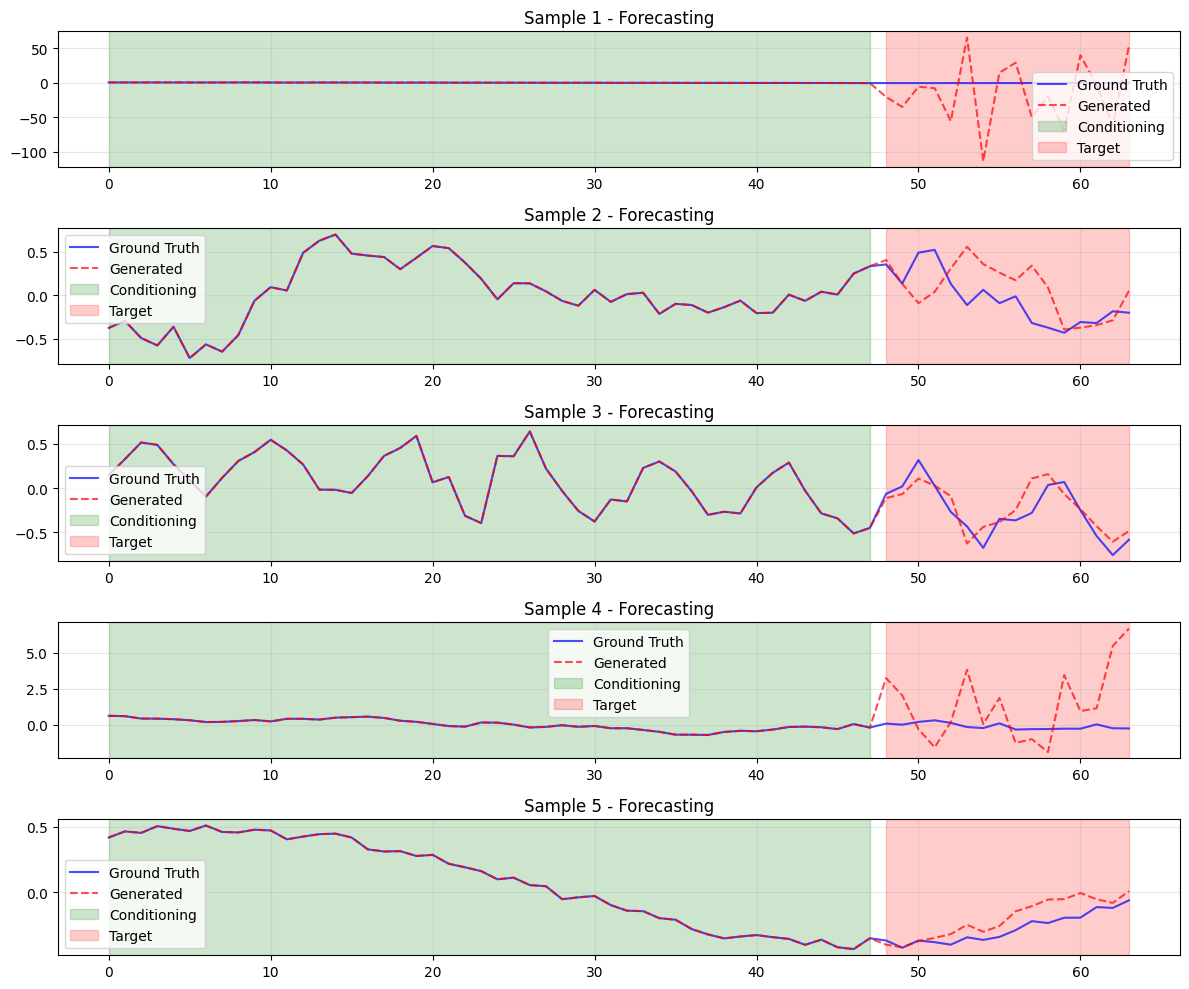

In [52]:
evaluate_model(ddpm_model, dataset, num_samples=5, num_inference_steps=100)